# Machine-learning Notebook - experimentation for calculating pick depth prediction from pick label classification prediction
- Machine_Learning_vB2_20170802
- A cleaner version of Machine_Learning_vB in the same folder
- preceeded by feature creation notebooks

In [11]:
import pandas as pd
import numpy as np
import itertools
# import matplotlib.pyplot as plt
# %matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
import dask
import dask.dataframe as dd
from dask.distributed import Client
# import pdvega
# import vega
import random
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error

In [12]:
import multiprocessing

In [13]:
print(welly.__version__)
print(dask.__version__)
print(pd.__version__)

0.3.5
0.18.2
0.23.3


In [14]:
#### Adding this bit to silence an error that was causing the notebook to have a dead kernal
#### This is an unsafe solution but couldn't get any  of the "right solutions" to work!
#### Ended up using this = https://www.kaggle.com/c/bosch-production-line-performance/discussion/25082
#### Other solutions = https://github.com/dmlc/xgboost/issues/1715 but the solution here didn't seem to work for me?


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

In [16]:
knn_dir = "../WellsKNN/"
load_dir = "../loadLAS"
features_dir = "../createFeatures/"
machine_learning_dir = "../Pre_ML_Rebalance_Splitting/"

## If you open this notebook fresh and jump to a point below where a pick file is read in, you still need to load everything above! 

----------

### Load dataframes for Machine-Learning via a HDF5 file

train_X
train_y
test_X
test_y

In [17]:
h5_to_load = 'df_all_Col_preSplit_wTrainTest_ClassBalanced_PreML_20181003.h5'
train_X = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_X')
train_y = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_y')
test_X = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_X')
test_y = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_y')

train_index = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_index')
test_index = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_index')

In [18]:
print(len(test_X))
print(len(test_y))
print(len(test_index))

255885
255885
255885


In [19]:
preSplitpreBal = pd.read_hdf(machine_learning_dir+h5_to_load, 'preSplitpreBal')


In [20]:
train_X.head()

,DEPT,DPHI,GR,ILD,NPHI,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI_min_21winSize_dirAroundMin,DPHI_min_21winSize_dirAboveMin,

--------------------

In [21]:
preSplitpreBal.head()

,DEPT,DPHI,GR,ILD,NPHI,UWI,trainOrTest,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,class_DistFrPick_TopTarget,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI

In [22]:
seed = 123

In [23]:
# .values.ravel()
model = XGBClassifier(
    gamma=0, 
    reg_alpha=0.3, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3,n_jobs=8)



In [ ]:
model.fit(train_X,train_y)

## Class Prediction Results for training dataframe or X

In [ ]:
result_train = model.predict(train_X)
result_train

In [ ]:
train_y_indexValues = train_y.index.values
df_result_train = pd.DataFrame(result_train, index=train_y_indexValues, columns=['TopTarget_Pick_pred'])
df_results_train_ = pd.concat([train_y, df_result_train], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
df_results_train_

In [ ]:
accuracy = accuracy_score(df_results_train_['class_DistFrPick_TopTarget'], df_results_train_['TopTarget_Pick_pred'])

In [ ]:
accuracy

## Class Prediction Results for Testing dataframe 

In [ ]:
len(test_X)

In [ ]:
result_test = model.predict(test_X)
result_test

In [ ]:
len(result_test)

In [ ]:
len(test_y)

In [ ]:
test_y_indexValues = test_y.index.values


In [ ]:
test_y_indexValues

In [ ]:
len(test_y_indexValues)

In [ ]:
df_result = pd.DataFrame(result_test, index=test_y_indexValues, columns=['TopTarget_Pick_pred'])

In [ ]:
df_results_test_ = pd.concat([test_y, df_result], axis=1)

In [ ]:
accuracy = accuracy_score(df_results_test_['class_DistFrPick_TopTarget'], df_results_test_['TopTarget_Pick_pred'])

In [ ]:
accuracy 

## Let's combine the test results with the test index now:

In [114]:
df_results_test_wIndex = pd.concat([df_results_test_, test_index], axis=1)

In [176]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH
11203,0,0,00/10-27-076-11W4/0,test,0,446.23
11204,0,0,00/10-27-076-11W4/0,test,0,446.23
11205,0,0,00/10-27-076-11W4/0,test,0,446.23
11206,0,0,00/10-27-076-11W4/0,test,0,446.23
11207,0,0,00/10-27-076-11W4/0,test,0,446.23


In [177]:
df_results_test_wIndex = pd.concat([df_results_test_wIndex, test_X[['DEPT']]], axis=1)

In [179]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224


--------

## Go from classifiers on rows to single pick per well and error bars

In [191]:
# y = pd.Series([0, 0, 0, 0, 0, 0, 0, 10, 95,100,100,10,10,10,10,10,100,100,100,100,0 ,0 ,0 ,0 ])
# x = pd.Series([10,11,12,13,14,15,16,17 ,18 ,19 ,20,21,22,23,24,25,26 , 27, 28,29, 30,31,32,33])

In [192]:
# sum(y)

In [193]:
def findMiddle(x,y):
    """
    Given two arrays, x and y where y has values and x is treated like an axis
    Check that they are equal length, if not return error
    If equal length, find length
    Add up all the y values, divide by number of x values to find the mean value, then starting from the base or top,
    Sum the y values along each x value until they equal or exceed the mean value, return that x value.
    """
    x_len = len(x)
    y_len = len(y)
    print("x_len =",x_len," and y_len is ",y_len)
    if (x_len != y_len):
        return "x and y are not the same length, please check the supplied series, thank you!"
    else:
        half_y = sum(y)/2
        print("avg_y",half_y)
        temp_sum = 0
        for i in range(y_len):
            print("i=",i)
            temp_sum = y[i] + temp_sum
            print("temp_sum",temp_sum)
            if(temp_sum >= half_y):
                return x[i]
            else:
                pass
    return "error in findMiddle function"

In [194]:
# test = findMiddle(x,y)
# test

In [195]:
def changeClassValues_partA(array_value):
    """
    Takes in an array, an array of values found in the first array, such as 0,10,50,100, and an array of ouputs of same lengh as inputs to that represents their new values
    For example, an array of values that are always 0, 60,95,100, such as [0,0,0,60,60,60,95,100,95,95,60,0,0] could be changed into values of 0s,10s,80s,and 100s. [0,0,0,10,10,10,80,100,80,80,10,0,0]
    One use case of this is to change the relative strength of each class when using it as labels or features or when calculating the weighted middle instance.
    """
    array_inputs = [0,10,60,70,95,100]
    array_outputs = [0,1,2,3,4,5]
    length_ofInputs = len([0,10,60,70,95,100])
    for i in range(length_ofInputs):
        if array_inputs[i] == array_value:
            return array_outputs[i]
    print("did not find a match between input array and output for given argument in changeClassValues_partA")
    return 0
        

In [196]:
# test = changeClassValues_partA(95)
# test

 apply this to a series = changeClassValues(array_value,array_inputs,array_outputs)

In [197]:
changeClassValues_partB = np.vectorize(changeClassValues_partA) #Convert python function to vector function
# test2 = np.apply_along_axis(changeClassValues_partB, 0,[0, 0, 10, 10, 95, 10,0,95,100,100,60,60,0,0,0,0])
# print(test2)

## Perhaps I'll make a few different predictions from the classifiers:
- Median
- Rolling mean 6
- Rolling mean 12
- Rolling Mean 20
- Sums of rolling all means 
## I can try to vary the differences between the classes by changing 100 to 150 or something?
## It would likely be useful to have some error bars as well! 
- One model would be plus or minus generated from greatest distance on either side there is anything other than zero?
- Another model would be to do same thing as above but only only use 95 class

-------------------

# Well by well calculation of single point predictions from classification prediction

https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

In [198]:
def findMiddleOfPreClassif(x,y):
    """
    Given two arrays, x and y where y has values and x is treated like an axis
    Check that they are equal length, if not return error
    If equal length, find length
    Add up all the y values, divide by number of x values to find the mean value, then starting from the base or top,
    Sum the y values along each x value until they equal or exceed the mean value, return that x value.
    """
    x_len = len(x)
    y_len = len(y)
#     print("x_len =",x_len," and y_len is ",y_len)
    if (x_len != y_len):
        return "x and y are not the same length, please check the supplied series, thank you!"
    else:
#         print("type y",type(y))
#         print("len y",len(y))
#         print("y",y)
        half_y = sum(y)*0.5
#         print("avg_y",half_y)
        temp_sum = 0
        for i in range(y_len):
#             print("i=",i)
            temp_sum = y[i][0] + temp_sum
#             print("temp_sum",temp_sum)
            if(temp_sum >= half_y[0]):
                return x[i]
            else:
                pass
    return "error in findMiddle function"

In [199]:
#df_results_train2_FullCol_vB = pd.concat([preSplitpreBal,df_results_train2_], axis=1)

In [200]:
#### INSTEAD OF LINE ABOVE WE ARE USING THIS NOW TO JUST WORK WITH TEST DATASET
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224


In [201]:
df_results_train2_FullCol_vB.head()

,DEPT,DPHI,GR,ILD,NPHI,UWI,trainOrTest,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,class_DistFrPick_TopTarget,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI_min_21winSize_d

In [202]:
# df_results_test_wIndex

In [10]:
def calcPredVsRealTopDif(df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
    """
    Function takes in:
        A dataframe with predictions and dataframe with UWIs and known pick depths. Dataframes may not be same length but df 2 must have all UWIs in df 1.
    Function returns:
        A column for predicted dataframe with calculated single prediction depth pick based on the median row technique
        A column for predicted dataframe with calculated single prediction depth pick based on rolling means of classes predicted for each row.
        A new dataframe that is just one row per well and includes as col of UWIs, known picks, predicted picks, and difference
        A new col in the new df that has high and low error by some metric?
        A score of mean abosolute error across all wells in the given dataframe 1.
    """

    df_merges = df.copy()
    all_new_rolling_mean_col = []
    for Window in rollingWindows:
        new_col = pick_pred_class_str+'_classRollMean'+str(Window)
        all_new_rolling_mean_col.append(new_col)
        half_window_neg = -1*math.floor(Window/2)
        df_merges[new_col] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(half_window_neg).rolling(Window).mean().fillna(0)
    df_merges[pick_pred_class_str+'classRollMeanSum'] = 0
    for col in all_new_rolling_mean_col:
        df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[col]
    df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[pick_pred_class_str]
    idx = df_merges.loc[df_merges.groupby(["UWI"])[pick_pred_class_str+'classRollMeanSum'].idxmax()] 
    #print('idx=',idx)
    print('type(idx)',type(idx))
#     print(idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']])
    max_frame = idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']]
    max_frame.columns = ['UWI',pick_pred_class_str+'_DEPT_pred',pick_pred_class_str+'_classRollMeanSum']
    #print("type",type(max_series),"and max series is ",max_series)
    df_merges = pd.merge(df_merges,max_frame, on='UWI', how='outer')
    return df_merges
    

In [205]:
calc_pred = calcPredVsRealTopDif(df_results_test_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])

type(idx) <class 'pandas.core.frame.DataFrame'>


In [206]:
calc_pred.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,0.0,0.0,0.0,0.0,449.474,361.363636
1,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,0.0,0.0,0.0,0.0,449.474,361.363636
2,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,0.0,0.0,0.0,0.0,449.474,361.363636
3,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,0.0,0.0,0.0,0.0,449.474,361.363636
4,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,0.0,0.0,0.0,0.0,449.474,361.363636


In [1]:
len(calc_pred)

NameError: name 'calc_pred' is not defined

In [211]:
#accuracy = accuracy_score(calc_pred['TopTarget_DEPTH'], calc_pred['TopTarget_Pick_pred_classRollMeanSum'])

In [212]:
#accuracy

In [213]:
calc_pred_noZeros = calc_pred.loc[calc_pred['TopTarget_Pick_pred_classRollMeanSum'] != 0]

In [214]:
# print(list(calc_pred_noZeros.groupby(['UWI'])['TopMcMr_Pick_predclassRollMeanSum_y']))

In [215]:
calc_pred_noZeros.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,0.0,0.0,0.0,0.0,449.474,361.363636
1,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,0.0,0.0,0.0,0.0,449.474,361.363636
2,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,0.0,0.0,0.0,0.0,449.474,361.363636
3,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,0.0,0.0,0.0,0.0,449.474,361.363636
4,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,0.0,0.0,0.0,0.0,449.474,361.363636


In [223]:
calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred = calc_pred_noZeros.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
calc_pred_noZeros_TopTarget_DEPTH = calc_pred_noZeros.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()



In [224]:
calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred

,UWI,TopTarget_Pick_pred_DEPT_pred
0,00/01-04-075-23W4/0,624.500
1,00/01-12-079-14W4/0,454.000
2,00/01-25-083-02W4/0,196.000
3,00/01-27-079-23W4/0,429.000
4,00/02-05-076-26W4/0,792.898
5,00/02-07-076-13W4/0,513.500
6,00/02-22-071-22W4/0,595.500
7,00/02-32-089-12W4/0,196.000
8,00/03-02-084-17W4/0,266.801
9,00/03-04-072-09W4/0,470.750


In [225]:
calc_pred_noZeros_TopTarget_DEPTH

,UWI,TopTarget_DEPTH
0,00/01-04-075-23W4/0,631.00
1,00/01-12-079-14W4/0,454.00
2,00/01-25-083-02W4/0,220.50
3,00/01-27-079-23W4/0,441.00
4,00/02-05-076-26W4/0,806.50
5,00/02-07-076-13W4/0,519.00
6,00/02-22-071-22W4/0,593.50
7,00/02-32-089-12W4/0,220.50
8,00/03-02-084-17W4/0,283.00
9,00/03-04-072-09W4/0,471.00


In [226]:
score = mean_squared_error(calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])

In [227]:
score

147.26678914899935

In [228]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [231]:
r2_score = r2_score(calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
r2_score

0.9947379948764857

In [233]:
mean_absolute_error = mean_absolute_error(calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
mean_absolute_error

7.4610761589402825

In [234]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [236]:
calc_pred_noZeros['diff'] = calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'] - calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred']

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1cce34d898>]],
      dtype=object)

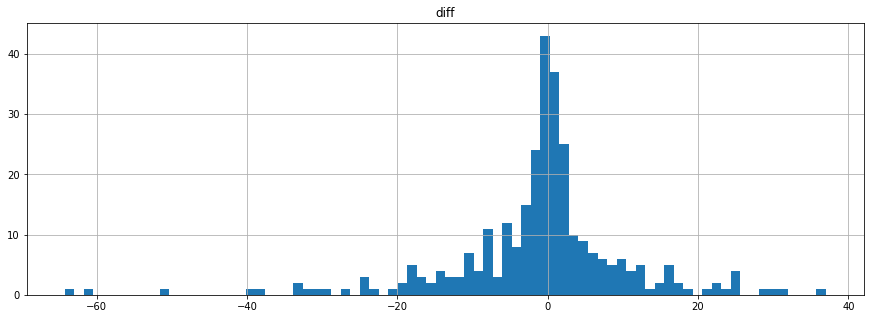

In [237]:
calc_pred_noZeros.hist(column='diff',bins=80,figsize=(15,5))

In [238]:
mean_error = calc_pred_noZeros['diff'].mean()
mean_error

-1.1611821192055352

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24b255c0>]],
      dtype=object)

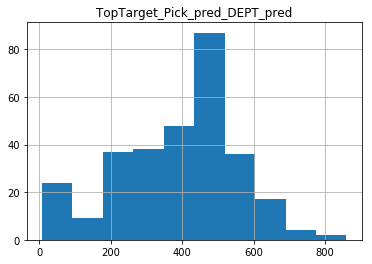

In [239]:
calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred.hist(column='TopTarget_Pick_pred_DEPT_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24c17518>]],
      dtype=object)

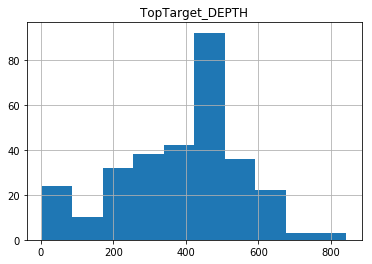

In [240]:
calc_pred_noZeros_TopTarget_DEPTH.hist(column='TopTarget_DEPTH')

THe quality controls are (-1) no pick, pick is unknown, or no data available, (0) pick is missing or eroded, high degree of condience based on a complete dataset and log suite, (1) good pick, with a high degree of condience based on geophysical log correlation and core control, (2) pick is highly interpretitve, but confirmed by surrounding wells (3) pick is uncertain, due to poor or missing data and/or low degree of confidence in correlation, and (4) pick is based on primary on drillers logs or other reliable drilling information.